# Creazione modelli per previsione SQUAT
> Decision TreeClassifier

> Logistic Regression 

> Regressione lineare multivariata

In [464]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn import tree
from matplotlib import pyplot as plt
import seaborn as sns

In [465]:
max_lunghezza_albero = 100
potatura = 0.001

shift = 6
rolling_p = 10

## Import dati

In [466]:
df_raw = pd.read_csv('/Users/lorenzobassetti/Dropbox/Quant/Python_DEV/artabax/Squatprob.csv' , sep=';' , decimal='.')
df_raw.set_index('Time', inplace=True)
# df

In [467]:
df = df_raw.copy()
# df = df.rolling(3).mean()


df_temp = df.loc[df['DOWN'] ==1]
pos = np.array(df_temp.index)
for i in pos:
    for k in range(-shift+1, shift, 1):
        df.at[i+k, 'DOWN'] =1

# df = df[df.columns.difference(['prob'])].rolling(3).mean()
df['Ax'] = df['Ax'].rolling(rolling_p).mean()
df['Ay'] = df['Ay'].rolling(rolling_p).mean()
df['Az'] = df['Az'].rolling(rolling_p).mean()
df['BAR'] = df['BAR'].rolling(rolling_p).mean()
df['Gx'] = df['Gx'].rolling(rolling_p).mean()
df['Gy'] = df['Gy'].rolling(rolling_p).mean()
df['Gz'] = df['Gz'].rolling(rolling_p).mean()




df.dropna(inplace=True)

In [468]:
df

,Ax,Ay,Az,Gx,Gy,Gz,BAR,P,R,Mag,UP,DOWN,prob
Time,,,,,,,,,,,,,
9,9.955140,1.714835,-1.173798,1.050,-0.105000,-0.770,994.794947,0,0,0,0,0,0.03935
10,9.882092,1.730402,-1.203257,1.694,0.756000,-0.364,994.788257,0,0,0,0,0,0.02793
11,9.703902,1.707170,-1.200622,2.611,2.211999,0.210,994.782862,0,0,0,0,0,0.01171
12,9.439252,1.638193,-1.173319,3.759,3.338999,0.091,994.779517,0,0,0,0,0,0.00546
13,9.194002,1.609213,-1.159189,4.438,4.920998,0.098,994.777490,0,0,0,0,0,0.00696
...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,9.738629,1.776386,2.336820,0.175,4.283998,-1.638,994.862940,0,0,0,0,0,0.20285
578,9.842813,1.787163,2.458248,-0.070,6.495997,-0.175,994.860059,0,0,0,0,0,0.52341
579,9.944122,1.801773,2.595483,-1.204,8.161996,1.463,994.857398,0,0,0,0,0,0.57682


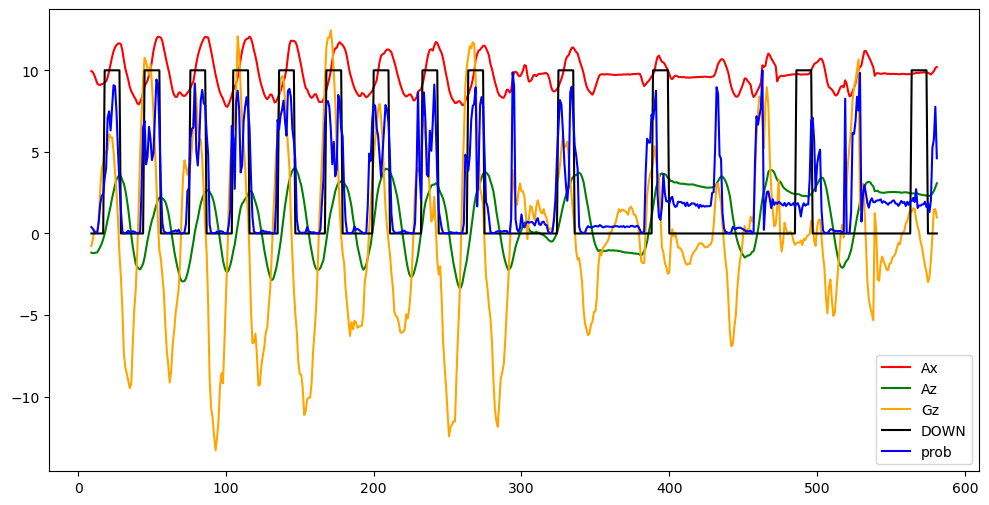

In [481]:
plt.figure(figsize=(12,6))
plt.plot(df['Ax'], color='red', label='Ax')
# plt.plot(df['Ay'], color='blue', label='Ay')
plt.plot(df['Az'], color='green', label='Az')
plt.plot(df['Gz'], color='orange', label='Gz')
plt.plot(df['DOWN']*10, color='black', label='DOWN')
plt.plot(df['prob']*10, color='blue', label='prob')
plt.legend()
plt.show()

## Preparazione datasets

In [470]:
## Y è l'output che utilizziamo come training
## X sono le feautures, BISOGNA togliere la Y dalle colonne feautures 
y = df['DOWN']
X = df.copy()
X.drop(columns=['DOWN','Mag','UP','prob'], axis=1, inplace=True)

##Divido il campione in Train e Test
X_train, X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Modelli

## DecisionTree Classifier

In [471]:
potatura = 0.005

Accuracy:   0.974
Precision:  0.676
Recall:     0.821


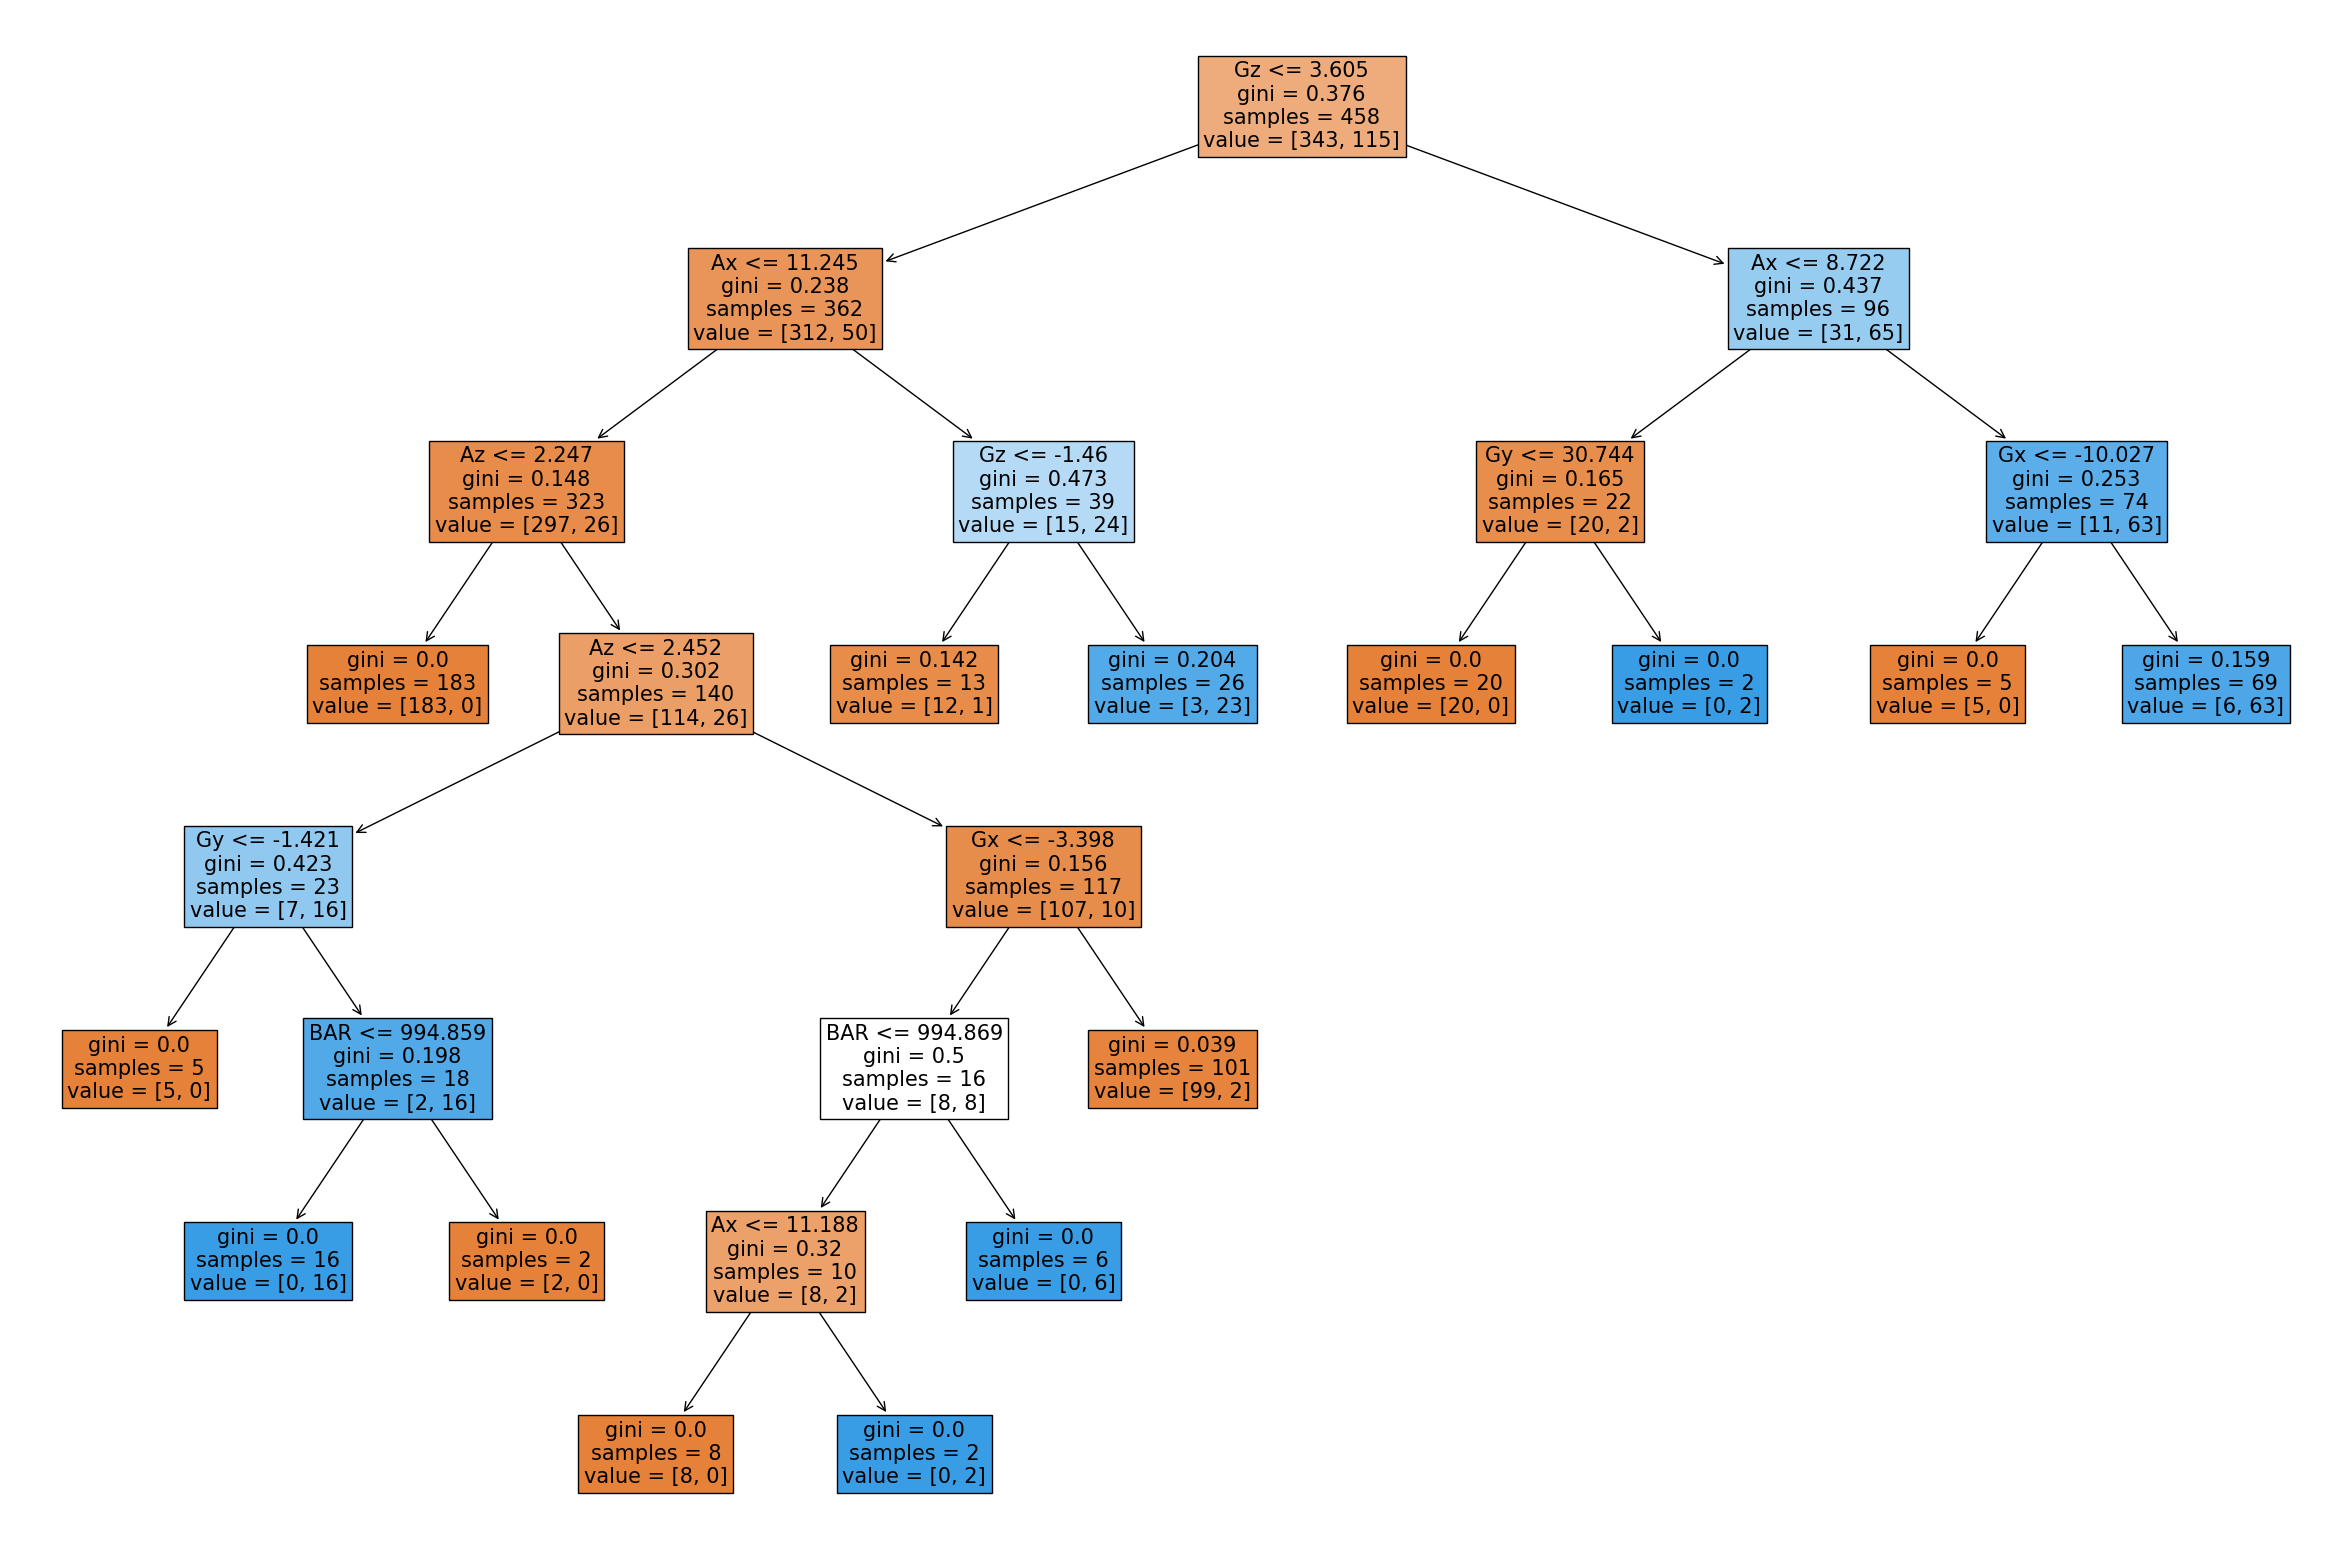

In [472]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=max_lunghezza_albero , ccp_alpha=potatura)
clf = clf.fit(X_train, y_train)
param = clf.get_params()
predictions = clf.predict(X_test)
accuracy = clf.score(X_train, y_train)
precision = precision_score(y_true= y_test, y_pred=predictions)
recall = recall_score(y_true= y_test, y_pred=predictions)

print('Accuracy:  ', round(accuracy,3))
print('Precision: ', round(precision,3))
print('Recall:    ', round(recall,3))

from sklearn import tree
feature_names = X.columns
fig = plt.figure(figsize=(30,20))
_= tree.plot_tree(clf, 
        feature_names=feature_names, 
        filled=True, fontsize=15)


In [473]:
##importanza features
feature_names = X.columns
feature_importance = pd.DataFrame(clf.feature_importances_, index=feature_names).sort_values(0, ascending=False)

print(feature_importance.head(10))
important_features = list(feature_importance[feature_importance[0]>0].index)
# feature_importance.head(10).plot(kind='bar')

            0
Gz   0.368729
Ax   0.284421
Az   0.131706
Gx   0.094150
Gy   0.065371
BAR  0.055623
Ay   0.000000
P    0.000000
R    0.000000


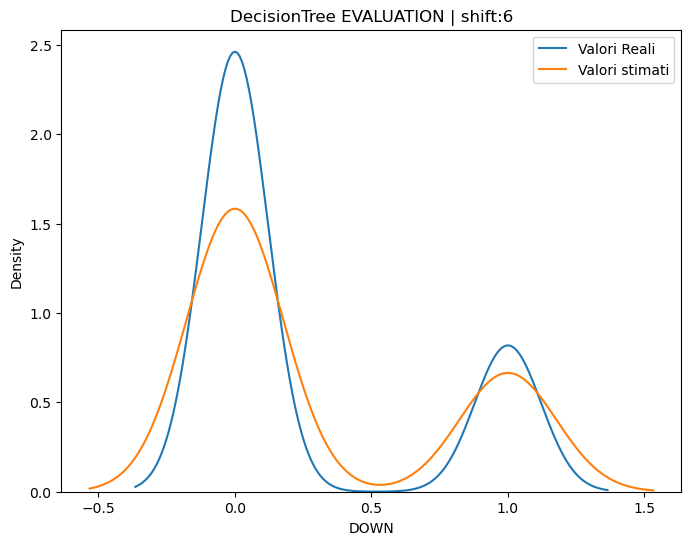

In [474]:
plt.figure(figsize=(8, 6))
plt.title('DecisionTree EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(predictions , label='Valori stimati')
plt.legend()
plt.show()

## Logistic Regression

In [475]:
log_reg = LogisticRegression(random_state=5, solver = 'lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)

# predict - Predict class labels for samples in X
y_pred = log_reg.predict(X_train)

# coef_ - Coefficient of the features in the decision function
log_reg.coef_

lr = pd.DataFrame(data =[X_train.columns, np.array(log_reg.coef_[0]).tolist()]).T
lr.rename(columns={0:'Reg',1:'Logistic'}, inplace=True)
lr.set_index('Reg', inplace=True)
lr.sort_values(by='Logistic', key=abs, ascending=False , inplace=True)
print(lr)
print('Termine noto:',log_reg.intercept_[0])

     Logistic
Reg          
Ay   -1.78909
Az   0.690842
Ax   0.397425
Gz   0.267222
Gy   0.094777
Gx   0.082149
BAR -0.003985
P         0.0
R         0.0
Termine noto: -3.512514457093812e-05


LogReg Training Accuracy is:  0.888646288209607
LogReg Testing Accuracy is:  0.8782608695652174


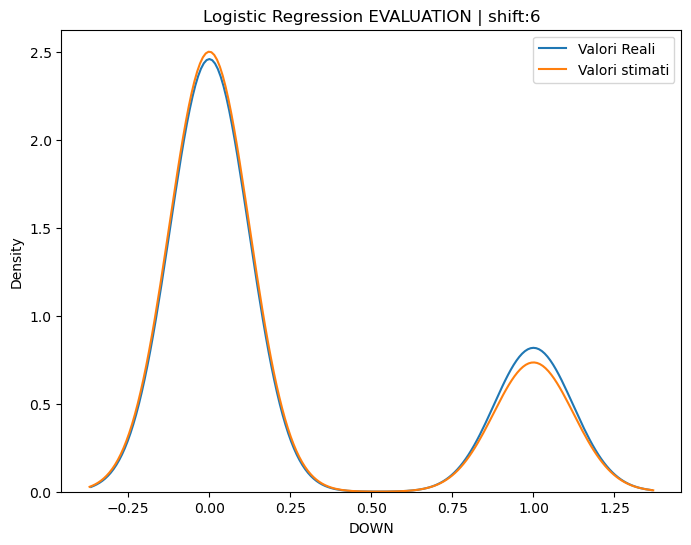

In [476]:
'''Logistic Regression EVALUATION'''

# Accuracy on Train
print("LogReg Training Accuracy is: ", log_reg.score(X_train, y_train))
# Accuracy on Test
print("LogReg Testing Accuracy is: ", log_reg.score(X_test, y_test))
# Classification Report

plt.figure(figsize=(8, 6))
plt.title('Logistic Regression EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(y_pred , label='Valori stimati')
plt.legend()
plt.show()


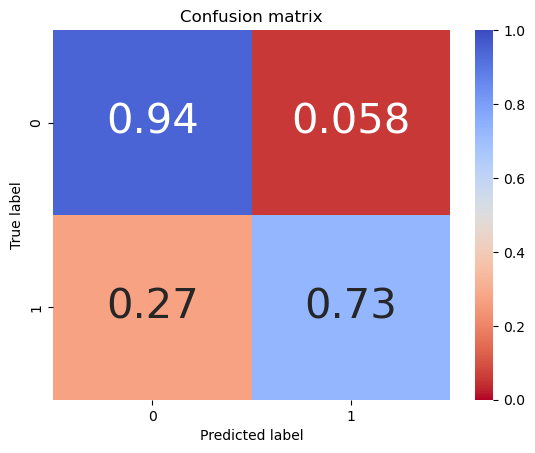

In [477]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="coolwarm_r", 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    vmin=0., vmax=1., 
                    annot=True, annot_kws={'size':30}
                    )
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Visualizing cm

cm = confusion_matrix(y_train, y_pred)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm_norm, classes = log_reg.classes_, title='Confusion matrix')

In [478]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print("The True Positive Rate is:", TPR)

# Precision or positive predictive value
PPV = TP / (TP + FP)
print("The Precision is:", PPV)

# False positive rate or False alarm rate
FPR = FP / (FP + TN)
print("The False positive rate is:", FPR)


# False negative rate or Miss Rate
FNR = FN / (FN + TP)
print("The False Negative Rate is: ", FNR)

The True Positive Rate is: [0.94169096 0.73043478]
The Precision is: [0.91242938 0.80769231]
The False positive rate is: [0.26956522 0.05830904]
The False Negative Rate is:  [0.05830904 0.26956522]


## Regressione Lineare Multivariata

           RLM
Reg           
prob  0.522756
Ay    -0.18704
Ax    0.055032
Gz    0.027389
Az   -0.013487
BAR   0.007553
Gx   -0.005279
Gy   -0.002264
P          0.0
R          0.0
Termine noto: -7.543216561337148
 
Precisione:  0.484392311598556


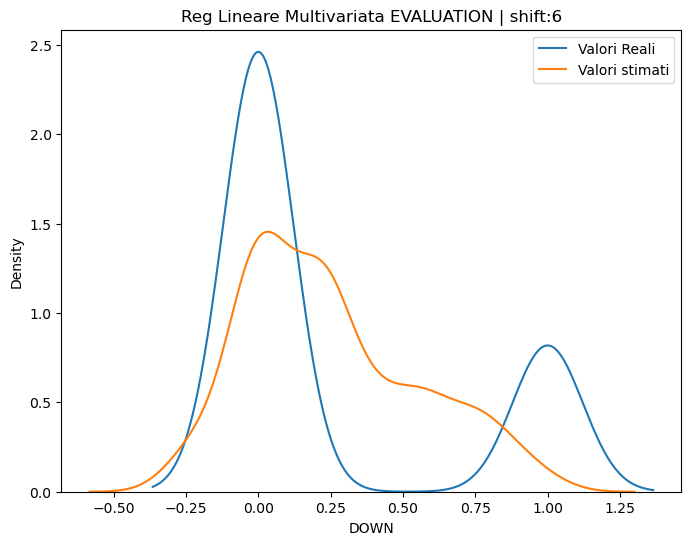

In [479]:
mlr = LinearRegression()
y = df['DOWN']
X = df.copy()
X.drop(columns=['DOWN','Mag','UP'], axis=1, inplace=True)

mlr.fit(X, y)
Y_hat = mlr.predict(X)
b0 = mlr.coef_
b1 = mlr.intercept_

reg = pd.DataFrame(data =[X.columns, b0]).T
reg.rename(columns={0:'Reg',1:'RLM'}, inplace=True)
reg.set_index('Reg', inplace=True)
reg.sort_values(by='RLM', key=abs, ascending=False , inplace=True)

print(reg)
print('Termine noto:',b1)
print(' ')
print('Precisione: ', mlr.score(X, y))

plt.figure(figsize=(8, 6))
plt.title('Reg Lineare Multivariata EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(Y_hat , label='Valori stimati')
plt.legend()
plt.show()
